#### Import libraries and packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import plotly.express as px


#### Import dataset

In [2]:
df = pd.read_csv("C:\\Users\\Admin\\Desktop\\BME 3\\BME-3\\dataset\\data_model.csv", parse_dates=True,index_col=0)

#### Create a new Timestamp column for time series forecasting

In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['quantity'].values.reshape(-1, 1)
df.head()

df

,quantity,Timestamp
time,,
2018-10-01,11.695247,1.538352e+09
2018-11-01,26.139366,1.541030e+09
2018-12-01,10.819778,1.543622e+09
2019-01-01,9.210340,1.546301e+09
2019-02-01,13.122363,1.548979e+09
2019-03-01,23.025851,1.551398e+09
2019-04-01,53.911887,1.554077e+09
2019-05-01,24.019103,1.556669e+09
2019-06-01,34.615737,1.559347e+09


#### Plotting line chart

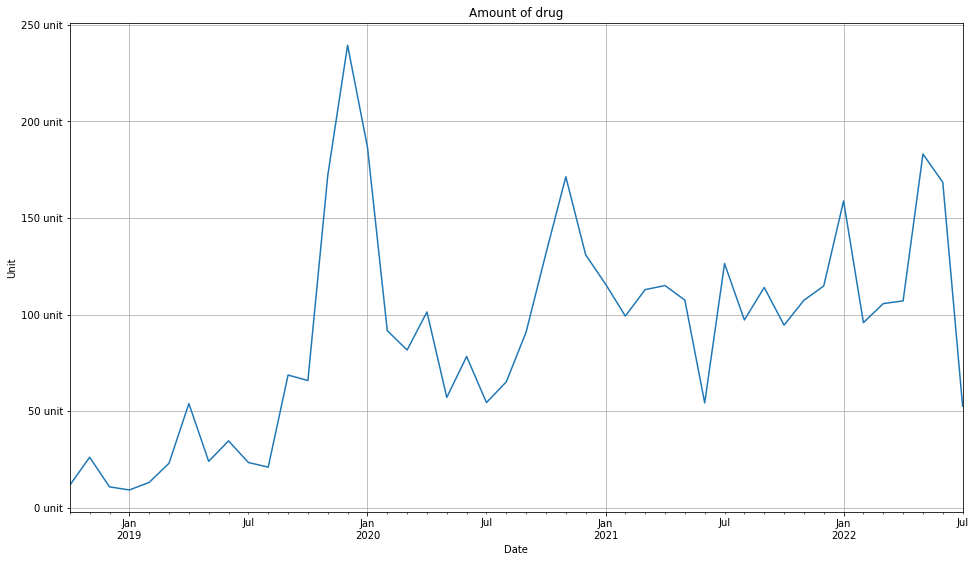

In [4]:
formatter = ticker.StrMethodFormatter('{x:,.0f} unit')

title = 'Amount of drug'
ylabel = 'Unit'
xlabel = 'Date'

ax = df['quantity'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

#### Normalizing / scaling data to facilitate model building

In [5]:
sc = StandardScaler()

df_scaled = df.copy()
df_scaled['quantity'] = sc.fit_transform(df_open)
df_scaled

,quantity,Timestamp
time,,
2018-10-01,-1.473724,1.538352e+09
2018-11-01,-1.204020,1.541030e+09
2018-12-01,-1.490071,1.543622e+09
2019-01-01,-1.520123,1.546301e+09
2019-02-01,-1.447077,1.548979e+09
2019-03-01,-1.262156,1.551398e+09
2019-04-01,-0.685444,1.554077e+09
2019-05-01,-1.243610,1.556669e+09
2019-06-01,-1.045747,1.559347e+09


In [6]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['quantity'] = y_scaled
df_scaled.head()

,Timestamp,quantity
time,,
2018-10-01,-1.694876,-1.473724
2018-11-01,-1.618168,-1.204020
2018-12-01,-1.543936,-1.490071
2019-01-01,-1.467228,-1.520123
2019-02-01,-1.390521,-1.447077


#### Split data for training and testing ( 8-2 )

In [7]:
interrupt = int(len(df) * .8)

train_data, test_data = df[:interrupt], df[interrupt:]
index_test = df.index[interrupt:]
print(train_data.shape)
print(test_data.shape)

(36, 2)
(10, 2)


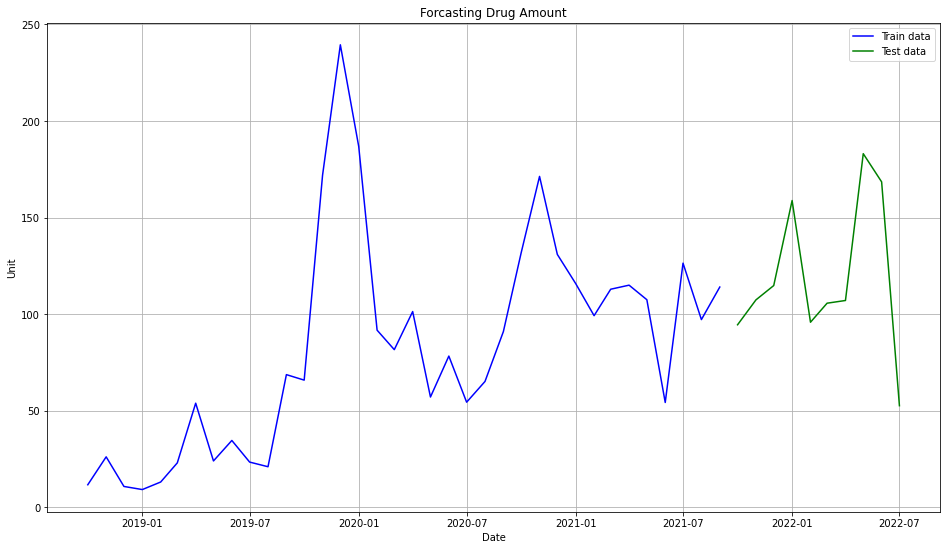

In [8]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Unit')
plt.xlabel('Date')
plt.title("Forcasting Drug Amount")
plt.plot(train_data['quantity'], 'blue', label='Train data')
plt.plot(test_data['quantity'], 'green', label='Test data')
plt.legend()

#### Determine the independent variable (X) and the dependent variable (y)

In [9]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['quantity'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['quantity'].values.reshape(-1, 1)

# Building model 

In [10]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 64%|██████▍   | 27/42 [00:00<00:00, 35.45it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(36, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.


100%|██████████| 42/42 [00:02<00:00, 20.82it/s]

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
TweedieRegressor                            -0.12       0.01    37.47   
DecisionTreeRegressor                       -0.14      -0.02    37.92   
ExtraTreeRegressor                          -0.14      -0.02    37.92   
ExtraTreesRegressor                         -0.14      -0.02    37.92   
XGBRegressor                                -0.14      -0.02    37.92   
ElasticNet                                  -0.16      -0.03    38.13   
GradientBoostingRegressor                   -0.16      -0.03    38.14   
GammaRegressor                              -0.16      -0.03    38.20   
AdaBoostRegressor                           -0.16      -0.03    38.26   
RandomForestRegressor                       -0.17      -0.04    38.39   
ElasticNetCV                                -0.22      -0.09    39.24   
BaggingRegressor                            -0.23  

In [11]:
top_10= models.sort_values(by='Adjusted R-Squared', ascending=False).head(12)
print(top_10)

                           Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                     
TweedieRegressor                        -0.12       0.01 37.47        0.01
DecisionTreeRegressor                   -0.14      -0.02 37.92        0.00
ExtraTreeRegressor                      -0.14      -0.02 37.92        0.02
ExtraTreesRegressor                     -0.14      -0.02 37.92        0.12
XGBRegressor                            -0.14      -0.02 37.92        0.89
ElasticNet                              -0.16      -0.03 38.13        0.01
GradientBoostingRegressor               -0.16      -0.03 38.14        0.06
GammaRegressor                          -0.16      -0.03 38.20        0.01
AdaBoostRegressor                       -0.16      -0.03 38.26        0.12
RandomForestRegressor                   -0.17      -0.04 38.39        0.13
ElasticNetCV                            -0.22      -0.09 39.24        0.07
BaggingRegressor         

### visualization of autoML

In [12]:
line = px.line(data_frame= models ,y =["Adjusted R-Squared"] , markers = True)
line.update_xaxes(title="Model",
                rangeslider_visible = False)
line.update_yaxes(title = "Adjusted R-Squared")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Ad R^2 vs Model',
        # 'y':0.94,
        # 'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

# Hyperparameter turning (in future)

In [13]:
def plot_pred_act(model):

    model.fit(X_train,y_train)
    pred = model.predict(X_test)

    inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
    inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(16, 9))
    plt.grid(True)
    plt.ylabel('Drug amount')
    plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
    plt.plot(column_or_1d(inv_pred), 'red', label='Predicted data')
    plt.legend()


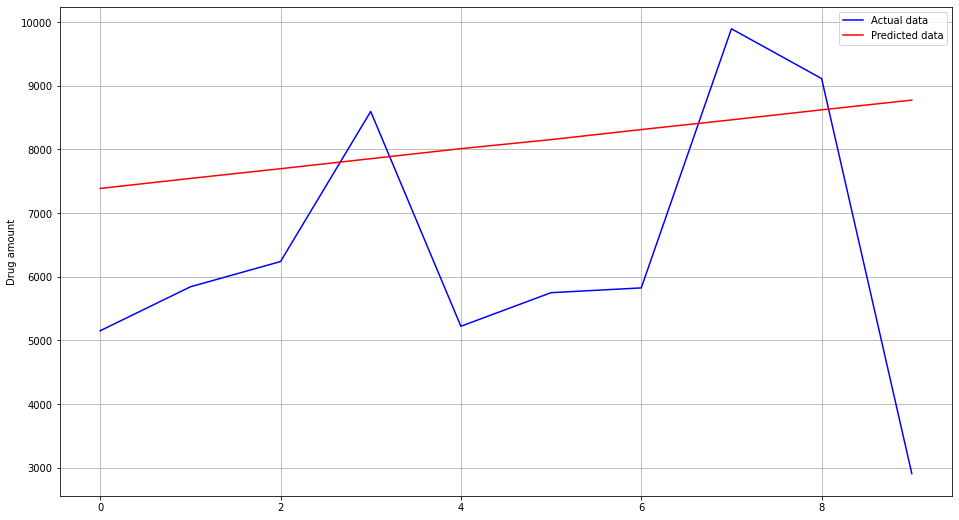

In [14]:
from sklearn.linear_model import LinearRegression

plot_pred_act(LinearRegression())

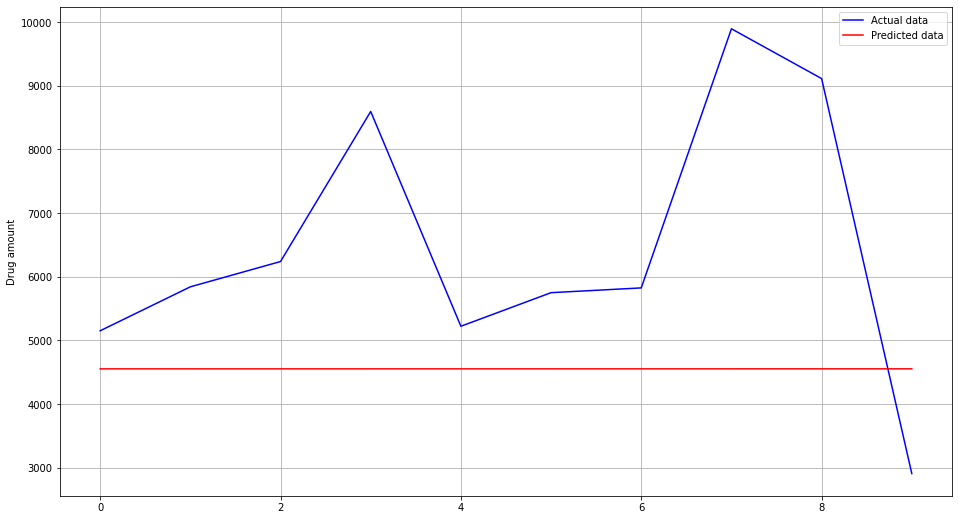

In [15]:
from sklearn.linear_model import TweedieRegressor

plot_pred_act(TweedieRegressor())

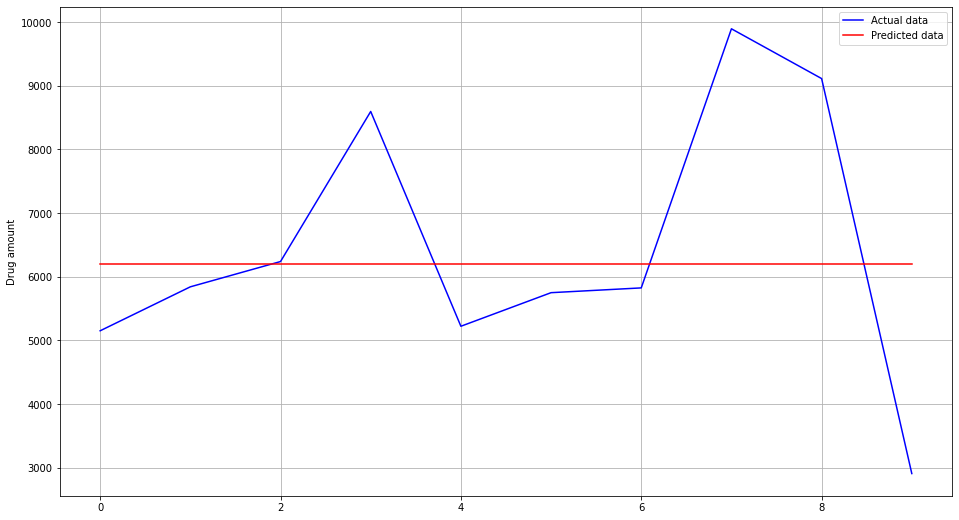

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

plot_pred_act(ExtraTreesRegressor())

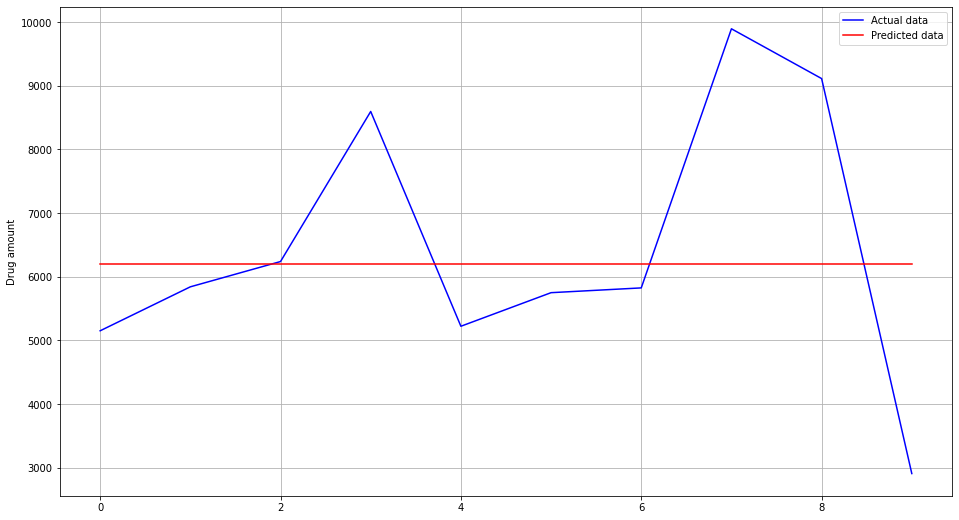

In [20]:

from sklearn.tree import DecisionTreeRegressor

plot_pred_act(DecisionTreeRegressor())

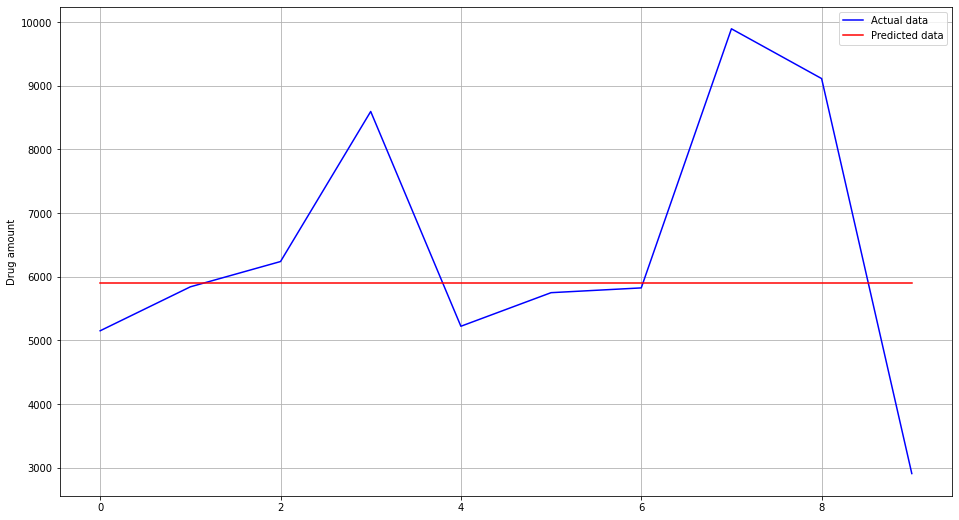

In [21]:
from sklearn.ensemble import RandomForestRegressor

plot_pred_act(RandomForestRegressor())

#### Try with Linear Regression (temp)

In [ ]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)
pred

#### Transform back to original form

In [ ]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))


#### Graph the test set and the prediction results

In [ ]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Drug amount')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'red', label='Predicted data')
plt.legend()

#### Model Evaluation

In [ ]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred) 
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse) 
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

In [ ]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred